# 05 GRU (Gated Recurrent Unit) Modelling

![Visualisation of GRU Network Node](images/gru_image.jpg)

The GRU, known as the Gated Recurrent Unit is an Deep Learning RNN architecture, which is similar to LSTM units. A node of a GRU consists of the reset gate and the update gate instead of the input, output and forget gate of the LSTM.

The __reset gate__ determines how to combine the new input with the previous memory.

The __update gate__  defines how much of the previous memory to keep around. 

If we set the reset to all 1’s and update gate to all 0’s we again arrive at our plain RNN model.

For the GRU the hidden state hₜ can be calculated as follows:

## Reshaping the train data

I found this nice explanation (https://github.com/deKeijzer/Multivariate-time-series-models-in-Keras/blob/master/notebooks/4.1%20CNN%20%26%20RNN%20Data%20Preperation.ipynb), why we have to split our dataframe into this complex numpy array representation:

### Visual explanation

Let $A$ be a (5 $\times$ 3) matrix, so 5 rows by 3 columns.  
There are 2 feautures $X$, column 1 is feature $X_1$ and column 2 is the second feature $X_2$.  
Column 3 is the target $y$.  
  

$A = \begin{bmatrix}
0 & 2 & 0.5 \\ 
1 & 4 & 1.0 \\ 
2 & 6 & 1.5 \\ 
3 & 8 & 2.0 \\ 
4 & 10 & 2.5 
\end{bmatrix}$

Or more precise, in numpy this would be in the form:

$ A = \begin{bmatrix}
\begin{bmatrix} 0 & 2 & 0.5 \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 & 1.0 \end{bmatrix} \\ 
\begin{bmatrix} 2 & 6 & 1.5 \end{bmatrix} \\ 
\begin{bmatrix} 3 & 8 & 2.0 \end{bmatrix} \\ 
\begin{bmatrix} 4 & 10 & 2.5 \end{bmatrix}
\end{bmatrix}$

This matrix is obtained by `df.values`.  
To prepare this for usage with CNN/RNN it has to be split in $X$ and $y$.  
Where $X$ for RNN is in the shape $(samples, timesteps, features)$ or for CNN in the shape $(height, width, channels)$.  
They practically can be used in the same way for timeseries data, so lets just pick the RNN termonology for now.  
Timesteps can be interpreted as 'lookback', i.e. the amount of timesteps being looked back to predict the $y$ value at said point.  

Next step is to split $A$ into the feature matrix $X$ and the target matrix $y$.

$ X = \begin{bmatrix}
\begin{bmatrix} 0 & 2 \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 \end{bmatrix} \\ 
\begin{bmatrix} 2 & 6 \end{bmatrix} \\ 
\begin{bmatrix} 3 & 8 \end{bmatrix} \\ 
\begin{bmatrix} 4 & 10 \end{bmatrix}
\end{bmatrix}$ $ \ \ \ \ \ \ \ \ \ \    y = \begin{bmatrix} 0.5 & 1.0 & 1.5 & 2.0 & 2.5 \end{bmatrix}$

Now say that timesteps (or lookback) equals 2.  
The idea is to use the two previous $X$ values to predict the current $y$ value.   

Then $\begin{bmatrix}
\begin{bmatrix} 0 & 2  \end{bmatrix} \\ 
\begin{bmatrix} 1 & 4 \end{bmatrix}
\end{bmatrix}$ will be used to predict $\begin{bmatrix}
\begin{bmatrix} 1.5 \end{bmatrix}
\end{bmatrix}$.  

Note that $\begin{bmatrix}
\begin{bmatrix} 0.5  \end{bmatrix} \\ 
\begin{bmatrix} 1.0 \end{bmatrix}
\end{bmatrix}$ cannot be predicted because the previous two $X$ values for them are not available.

To get this done $X$ has to be reshaped to size $(samples, timesteps, features)$.

$ X = \begin{bmatrix} \begin{bmatrix}
\begin{bmatrix} 0 & 2 \end{bmatrix} \\
\begin{bmatrix} 1 & 4 \end{bmatrix}
\end{bmatrix} \\ 
\begin{bmatrix}
\begin{bmatrix} 1 & 4 \end{bmatrix} \\
\begin{bmatrix} 2 & 6 \end{bmatrix}
\end{bmatrix} \\
\begin{bmatrix}
\begin{bmatrix} 2 & 6 \end{bmatrix} \\
\begin{bmatrix} 3 & 8 \end{bmatrix}
\end{bmatrix} \end{bmatrix}  \ \ \ \ \ $ to predict  $ \ \ \ \ \     y = \begin{bmatrix} 1.5 & 2.0 & 2.5 \end{bmatrix}$

Finally, $X$ and $y$ can be used as input for a CNN/RNN network.

### Resources

  * The code in this notebook is inspired by: https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-GRU/Multivariate-3-GRU.ipynb
  * Visual and Easy Explanation of Deep Learning LSTM/GRU: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
  * Explanation of Data Preprocessing for Keras GRU: https://github.com/deKeijzer/Multivariate-time-series-models-in-Keras

In [1]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import data_prep_helper
plt.style.use('ggplot')

Using TensorFlow backend.


## Data Preprocessing for GRU Modeling

On meeting an specific loss level of 0.0001 before running through all epochs the Model Fitting will exit early:

In [2]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

I'm using my prepared class for preparing my input data and will put it into __df__ for Modelling:

In [143]:
# Loading the dataset
do = data_prep_helper.ShiftChartData(chart_col=["Price", "High", "Low"])

In [144]:
df = do.chart_df

In [145]:
df.columns

Index(['bitcoin_Price', 'bitcoin_High', 'bitcoin_Low', 'sp500_Price',
       'sp500_High', 'sp500_Low', 'dax_Price', 'dax_High', 'dax_Low',
       'googl_Price', 'googl_High', 'googl_Low', 'gold_Price', 'gold_High',
       'gold_Low', 'alibaba_Price', 'alibaba_High', 'alibaba_Low',
       'amazon_Price', 'amazon_High', 'amazon_Low', 'bitcoin_Google_Trends',
       'cryptocurrency_Google_Trends', 'trading_Google_Trends',
       'bitcoin_pos_sents', 'bitcoin_neg_sents', 'bitcoin_quot_sents',
       'economy_pos_sents', 'economy_neg_sents', 'economy_quot_sents'],
      dtype='object')

I will use features that showed good results for SARIMAX prediction or rather were analyzed during Correlation and Causality Analyis. It would be beneficial to optimize features by trying on all different sets of features but I have a lack of computing resources to do this in a reasonable time:

In [255]:
features = [ 'bitcoin_Price_prev_month',
             'alibaba_Price_prev_month',
             'alibaba_High_prev_month',
             'amazon_High_prev_month',
             'bitcoin_Google_Trends_prev_month',
             'economy_pos_sents_prev_month',
             'cryptocurrency_Google_Trends_prev_month',
             ]


In [235]:
#creating the train and validation set
train = df[:1350]
val = df[1350:1500]
test = df[1500:]

In [236]:
train = do.get_causal_const_shift(train, past="all")[features]
val = do.get_causal_const_shift(val, past="all")[features]
test = do.get_causal_const_shift(test, past="all")[features]

I scale Train, Validate and Test DataSet with a MinMax Scaler to the range of {0,1} for beeing more suitable for GRU than absolute ranges. For preventing Data Leakage it's important to scale every data component on it's own. 

In [237]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train)

sc = MinMaxScaler()
val = sc.fit_transform(val)

sc = MinMaxScaler()
test = sc.fit_transform(test)
print(train.shape,val.shape,test.shape)

(1319, 7) (119, 7) (358, 7)


## Assistance Function for Model Preparation

In [1]:
#Build and train the model
def fit_model(train, val, lookback, hl, lr, batch, epochs):
    # Function from https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-GRU/Multivariate-3-GRU.ipynb
    '''
    Fitting the GRU model by reshaping the input training and validate data into the
    right dimension. Compose the layers for the Deep Learning Model and fitting the model.
    
    INPUT:
        train - (np.array) Input Traning Data for fitting the model
        val - (np.array) Input Validate Data for model feedback
        lookback - (int) number of timesteps to look back to predict the current one
        hl - (list of int) of different output dimensions for GRU layers
        lr - (float) learning rate for Adam optimizer
        batch - (int) Number of data points per full layer calculation
        epochs - (int) Number of full Training Iterations
    OUTPUT:
        model - (keras GRU model) includes the fitted GRU model
        history['loss'] - (np.array) Train Loss Values over Epochs
        history['val_loss'] - (np.array) Validate Loss Values over Epochs
    '''
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Prepare Train Data from Pandas Series to Numpy compliant Matrix 
    # and split Input DataFrame into Features and Result Vector
    for i in range(lookback,train.shape[0]):
        X_train.append(train[i-lookback:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Do the Same for the Validation Data
    for i in range(lookback,val.shape[0]):
        X_val.append(val[i-lookback:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    # composing the GRU layers, honestly doesn't fully understand the advantages of this explicit architecture therefore I've to do a lot more Deep Learning research
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    # matrix multiplication that will apply the new weights to the trainable parameters
    model.add(Dense(1))
    # Adam is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [2]:
# Evaluating the model
def evaluate_model(model,test,lookback):
    # Function from https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis/blob/master/Multivatiate-GRU/Multivariate-3-GRU.ipynb
    '''
    Predicts the test data against the fitted GRU model and calculates
    multiple error values for evaluation.
    
    INPUT:
        model - (keras GRU model)
        test - (DataFrame) with the time series test split
        lookback - (int) Timesteps to look into the past
    OUTPUT:
        mse - (float) mean-squared-error between true and prediction chart
        rmse - (float) root-mean-squared-error between true and prediction chart
        r2 - (float) r2 error between true and prediction chart
        Y_test - (np.array) scaled true chart
        Y_hat - (np.array) scaled prediction chart
    '''
    
    X_test = []
    Y_test = []

    # Prepare Test Data from Pandas Series to Numpy compliant Matrix 
    # and split Input DataFrame into Features and Result Vector
    for i in range(lookback,test.shape[0]):
        X_test.append(test[i-lookback:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  

    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse, rmse, r2, Y_test, Y_hat
  

In [93]:
# Plotting the predictions
def plot_data(Y_test,Y_hat, ax="", title=""):
    '''
    Plots the test-data against the prediction-data
    '''
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax

    plot.plot(Y_test,c = 'r')
    plot.plot(Y_hat,c = 'y')
    plot.set_xlabel('Day')
    plot.set_ylabel('Price')
    if not title:
        plot.set_title("Stock Price Prediction using Multivariate-GRU")
    else:
        plot.set_title(title)
    plot.legend(['Actual','Predicted'],loc = 'lower right')
    #plot.show()

In [94]:
# Plotting the training errors
def plot_error(train_loss,val_loss, ax="", title=""):
    '''
    Plots the train loss of error against the validation loss of error.
    '''
    if ax:
        plot = ax
    else:
        fig, ax = plt.subplots(1, 1)
        plot = ax
        
    plot.plot(train_loss,c = 'r')
    plot.plot(val_loss,c = 'b')
    plot.set_ylabel('Loss')
    plot.set_xlabel('Epochs')
    if not title:
        plot.set_title('Loss Plot')
    else:
        plot.set_title(title)
    plot.legend(['train','val'],loc = 'lower right')
    #plot.show()

## Model Building

Hyperparameters for the Multivariate GRU Model:

In [242]:
# Lookback describes how many data points we will look into the past to describe the current data point
lookback = 5
# dimensions of the output of the layer
hl = [40,35]
# learning rate for adam algorithm optimization https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
lr = 1e-4
# number of data points in the training set to update network weights in one iteration
batch_size = 64
# number of complete iterations over my input dataset, one iteration consists of len(train)/batch_size batches
num_epochs = 200

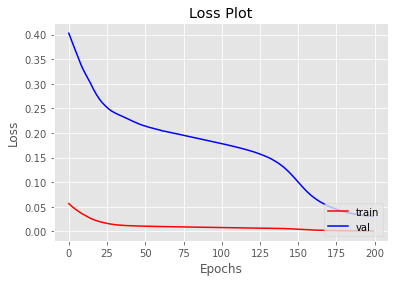

In [243]:
model,train_error,val_error = fit_model(train,
                                        val,
                                        lookback,
                                        hl,
                                        lr,
                                        batch_size,
                                        num_epochs)
plot_error(train_error,val_error)

MSE = 0.08156038601678985
RMSE = 0.28558779038465537
R2-Score = -0.41910356938131343


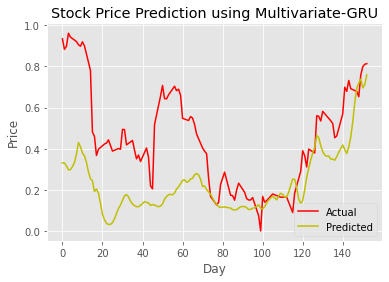

In [391]:
mse,rmse,r2_value,true,predicted = evaluate_model(model, test, 5)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [337]:
# Save a model
model.save('models/gru_12_feat_month.h5')

## Cross Validation

As for the SARIMAX model I will do a Cross Validation for the GRU as well. The characteristics of the Bitcoin Chart course does change tremendously for differnt timespans. Therefore it's important to look at multiple timesplits:

In [387]:
# Lookback describes how many data points we will look into the past to describe the current data point
lookback = 5
# dimensions of the output of the layer
hl = [40,35]
# learning rate for adam algorithm optimization https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
lr = 1e-4
# number of data points in the training set to update network weights in one iteration
batch_size = 64
# number of complete iterations over my input dataset, one iteration consists of len(train)/batch_size batches
num_epochs = 200

In [388]:
do = data_prep_helper.ModelData(chart_col=["Price", "High", "Low"])

In [389]:
def gen_scaled_train_val_test(df, split=""):
    '''
    Generator for returning multiple shifted splits for GRU Cross Validation.
    The default arguments are optimized for one split (main model split) to return.

    INPUT:
        df - (list of str) Input DataFrame to split
        splits - (int) number of total splits

    OUTPUT:      
        (train, val, test, split_number) - Generator(DataFrame, DataFrame, DataFrame, int) 
                                           train, validate and test datasets and number of split
    '''
    if split:
        split_range = range(0,split)
    else:
        split_range = range(2,3)
    for split_number in split_range:
        train = df[:900+(split_number*300)]
        val = df[900+(split_number*300):1100+(split_number*300)]
        test = df[1100+(split_number*300):]    

        train = do.get_causal_const_shift(train, past="all")[features]
        val = do.get_causal_const_shift(val, past="all")[features]
        test = do.get_causal_const_shift(test, past="all")[features]

        sc = MinMaxScaler()
        train = sc.fit_transform(train)
        sc = MinMaxScaler()
        val = sc.fit_transform(val)
        sc = MinMaxScaler()
        test = sc.fit_transform(test)
        
        yield train, val, test, split_number

Epoch 00092: early stopping
S_0_MSE: 0.056550575222985545
S_0_RMSE: 0.2378036484644118
S_0_R2: -0.23226556658580688
S_1_MSE: 0.009690142995983496
S_1_RMSE: 0.09843852394252718
S_1_R2: 0.867726462440249
S_2_MSE: 0.08156038601678985
S_2_RMSE: 0.28558779038465537
S_2_R2: -0.41910356938131343


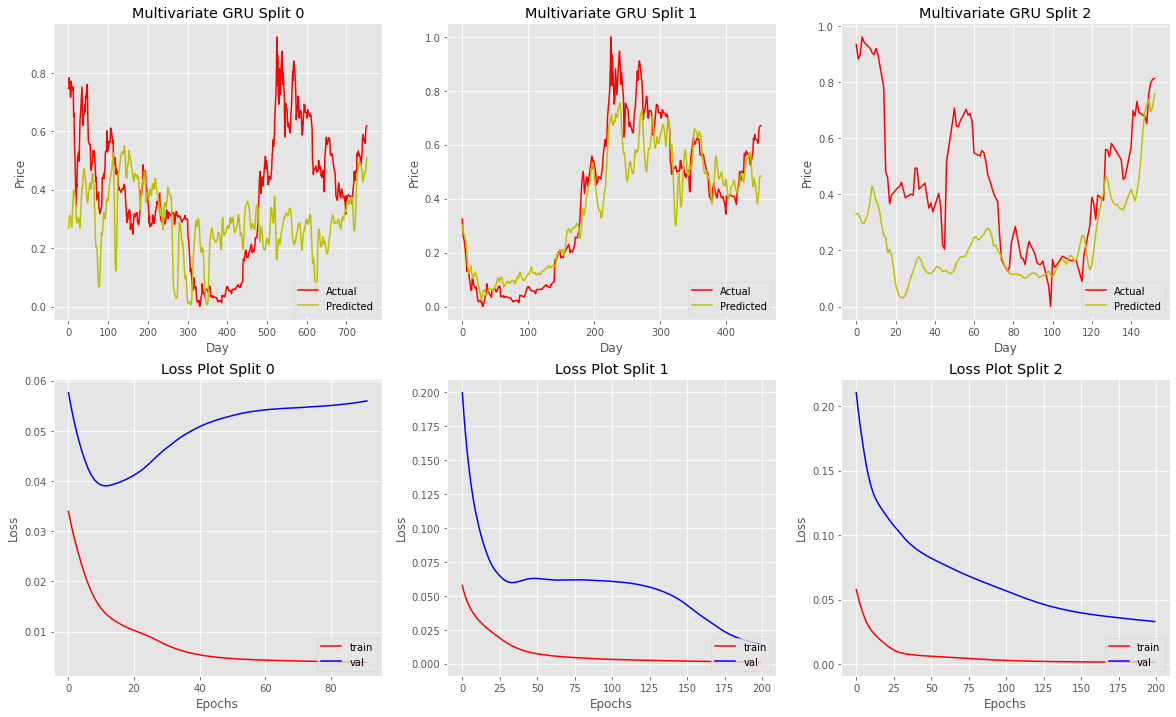

In [390]:
result_dict={}
fig, ax = plt.subplots(2, 3, figsize=(20,12))

for train,val,test,split_index in gen_scaled_train_val_test(do.chart_df,split=3):
    
    cross_val_results = list()
    train_loss = pd.DataFrame()
    val_loss = pd.DataFrame()
    model,train_error,val_error = fit_model(train, 
                                            val, 
                                            lookback, 
                                            hl, 
                                            lr,
                                            batch_size,
                                            num_epochs)
    model.save('models/gru_12_feat_month_S{}.h5'.format(split_index))

    
    mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
    result_dict["S_{}_MSE".format(split_index)] = mse
    result_dict["S_{}_RMSE".format(split_index)] = rmse
    result_dict["S_{}_R2".format(split_index)] = r2_value

    plot_data(true, predicted, ax[0][split_index], "Multivariate GRU Split {}".format(split_index))
    plot_error(train_error, val_error, ax[1][split_index], "Loss Plot Split {}".format(split_index))
    
for key, val in result_dict.items():
    print("{}: {}".format(key, val))

From my point of view, the second and third split are good enough to give them a try for forecasting. The first dplits cross validation looks really poor especially as the error loss for the validate data won't narrow to null. The split between Train and Validate are there at the crucial point in the history of Bitcoin Chart, where it starts to rise extremely and become really volatile. Therefore it cannot fit well.